# L-SeqSleepNet — Evaluation Results Visualization

Visualizes evaluation results from `custom/evaluation/`:
- Overall metrics summary
- Confusion matrix heatmap
- Per-subject accuracy distribution
- F1-score per sleep stage
- Per-subject metrics comparison

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.gridspec import GridSpec

# ── Absolute paths ────────────────────────────────────────────────────────────
NOTEBOOK_DIR = os.path.abspath(os.path.dirname('__file__') if '__file__' in dir() else os.getcwd())
EVAL_DIR     = os.path.abspath(os.path.join(NOTEBOOK_DIR, 'evaluation'))

# Load data
df_sub   = pd.read_csv(os.path.join(EVAL_DIR, 'per_subject_metrics.csv'))
df_cm    = pd.read_csv(os.path.join(EVAL_DIR, 'confusion_matrix.csv'), index_col=0)
with open(os.path.join(EVAL_DIR, 'overall_metrics.json')) as f:
    overall = json.load(f)

STAGE_NAMES  = ['W', 'N1', 'N2', 'N3', 'REM']
STAGE_COLORS = ['#4e79a7', '#f28e2b', '#59a14f', '#e15759', '#76b7b2']

print(f"Subjects evaluated : {overall['n_subjects']}")
print(f"Total epochs       : {overall['n_epochs']}")
print(f"Overall accuracy   : {overall['accuracy']:.4f}")
print(f"Cohen's Kappa      : {overall['kappa']:.4f}")
print(f"Mean F1            : {overall['mean_f1']:.4f}")

Subjects evaluated : 38
Total epochs       : 31825
Overall accuracy   : 0.4228
Cohen's Kappa      : 0.0000
Mean F1            : 0.1189


## 1. Overall Metrics Summary

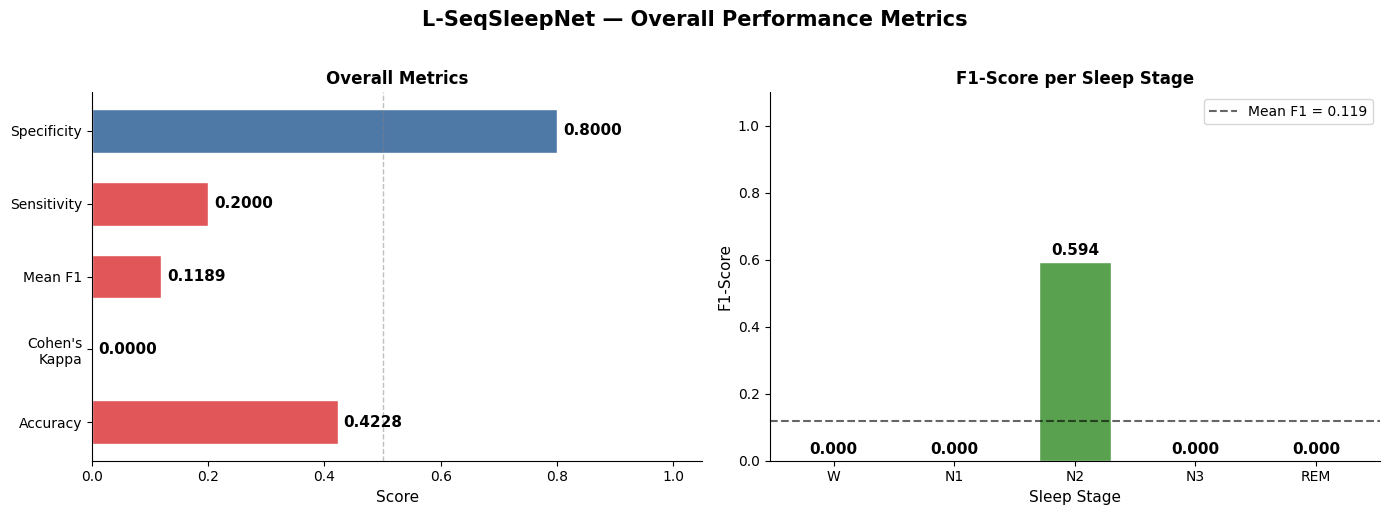

Saved: fig_overall_metrics.png


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('L-SeqSleepNet — Overall Performance Metrics', fontsize=15, fontweight='bold', y=1.02)

# ── Left: Scalar metrics bar chart ───────────────────────────────────────────
ax = axes[0]
metric_names  = ['Accuracy', "Cohen's\nKappa", 'Mean F1', 'Sensitivity', 'Specificity']
metric_values = [
    overall['accuracy'],
    overall['kappa'],
    overall['mean_f1'],
    overall['sensitivity'],
    overall['specificity'],
]
colors = ['#4e79a7' if v >= 0.5 else '#e15759' for v in metric_values]
bars = ax.barh(metric_names, metric_values, color=colors, edgecolor='white', height=0.6)
for bar, val in zip(bars, metric_values):
    ax.text(min(val + 0.01, 0.95), bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=11, fontweight='bold')
ax.set_xlim(0, 1.05)
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Score', fontsize=11)
ax.set_title('Overall Metrics', fontsize=12, fontweight='bold')
ax.spines[['top', 'right']].set_visible(False)

# ── Right: F1 per sleep stage ─────────────────────────────────────────────────
ax2 = axes[1]
f1_values = [
    overall['f1_W'],
    overall['f1_N1'],
    overall['f1_N2'],
    overall['f1_N3'],
    overall['f1_REM'],
]
bars2 = ax2.bar(STAGE_NAMES, f1_values, color=STAGE_COLORS, edgecolor='white', width=0.6)
for bar, val in zip(bars2, f1_values):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax2.set_ylim(0, 1.1)
ax2.axhline(overall['mean_f1'], color='black', linestyle='--', alpha=0.6,
            linewidth=1.5, label=f"Mean F1 = {overall['mean_f1']:.3f}")
ax2.legend(fontsize=10)
ax2.set_xlabel('Sleep Stage', fontsize=11)
ax2.set_ylabel('F1-Score', fontsize=11)
ax2.set_title('F1-Score per Sleep Stage', fontsize=12, fontweight='bold')
ax2.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(EVAL_DIR, 'fig_overall_metrics.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: fig_overall_metrics.png')

## 2. Confusion Matrix

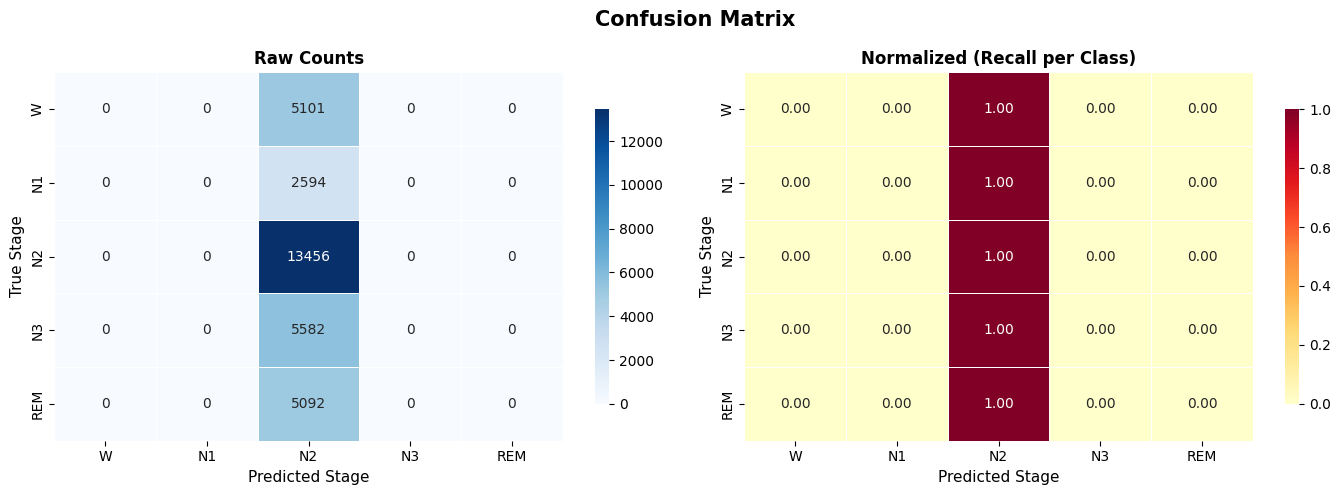

Saved: fig_confusion_matrix.png


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Confusion Matrix', fontsize=15, fontweight='bold')

cm_raw = df_cm.values.astype(float)

# ── Left: Raw counts ──────────────────────────────────────────────────────────
ax = axes[0]
sns.heatmap(cm_raw, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=STAGE_NAMES, yticklabels=STAGE_NAMES,
            linewidths=0.5, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_xlabel('Predicted Stage', fontsize=11)
ax.set_ylabel('True Stage', fontsize=11)
ax.set_title('Raw Counts', fontsize=12, fontweight='bold')

# ── Right: Normalized (row = recall per class) ────────────────────────────────
ax2 = axes[1]
row_sums = cm_raw.sum(axis=1, keepdims=True)
cm_norm  = np.where(row_sums > 0, cm_raw / row_sums, 0)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=STAGE_NAMES, yticklabels=STAGE_NAMES,
            linewidths=0.5, ax=ax2, vmin=0, vmax=1,
            cbar_kws={'shrink': 0.8})
ax2.set_xlabel('Predicted Stage', fontsize=11)
ax2.set_ylabel('True Stage', fontsize=11)
ax2.set_title('Normalized (Recall per Class)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(EVAL_DIR, 'fig_confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: fig_confusion_matrix.png')

## 3. Per-Subject Accuracy Distribution

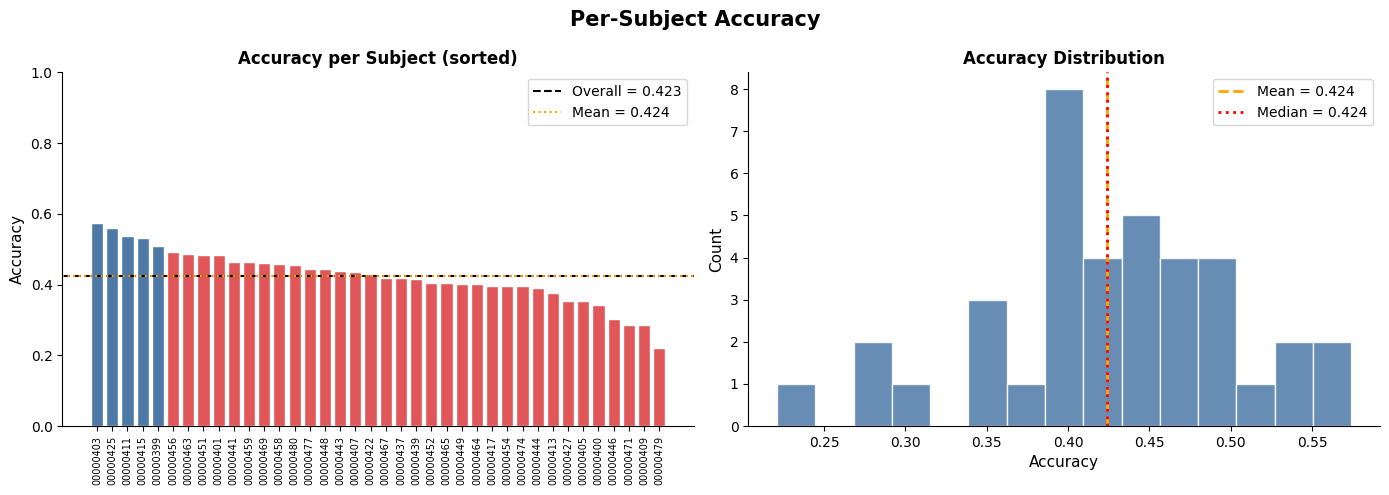

Saved: fig_per_subject_accuracy.png


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Per-Subject Accuracy', fontsize=15, fontweight='bold')

df_sorted = df_sub.sort_values('accuracy', ascending=False).reset_index(drop=True)
short_ids = [sid.split('-')[0] for sid in df_sorted['subject_id']]

# ── Left: Bar chart per subject ───────────────────────────────────────────────
ax = axes[0]
bar_colors = ['#4e79a7' if v >= 0.5 else '#e15759' for v in df_sorted['accuracy']]
ax.bar(range(len(df_sorted)), df_sorted['accuracy'], color=bar_colors, edgecolor='white')
ax.axhline(overall['accuracy'], color='black', linestyle='--', linewidth=1.5,
           label=f"Overall = {overall['accuracy']:.3f}")
ax.axhline(df_sorted['accuracy'].mean(), color='orange', linestyle=':', linewidth=1.5,
           label=f"Mean = {df_sorted['accuracy'].mean():.3f}")
ax.set_xticks(range(len(df_sorted)))
ax.set_xticklabels(short_ids, rotation=90, fontsize=7)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Accuracy per Subject (sorted)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.spines[['top', 'right']].set_visible(False)

# ── Right: Histogram ──────────────────────────────────────────────────────────
ax2 = axes[1]
ax2.hist(df_sub['accuracy'], bins=15, color='#4e79a7', edgecolor='white', alpha=0.85)
ax2.axvline(df_sub['accuracy'].mean(), color='orange', linestyle='--', linewidth=2,
            label=f"Mean = {df_sub['accuracy'].mean():.3f}")
ax2.axvline(df_sub['accuracy'].median(), color='red', linestyle=':', linewidth=2,
            label=f"Median = {df_sub['accuracy'].median():.3f}")
ax2.set_xlabel('Accuracy', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Accuracy Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(EVAL_DIR, 'fig_per_subject_accuracy.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: fig_per_subject_accuracy.png')

## 4. F1-Score per Stage — Per Subject Heatmap

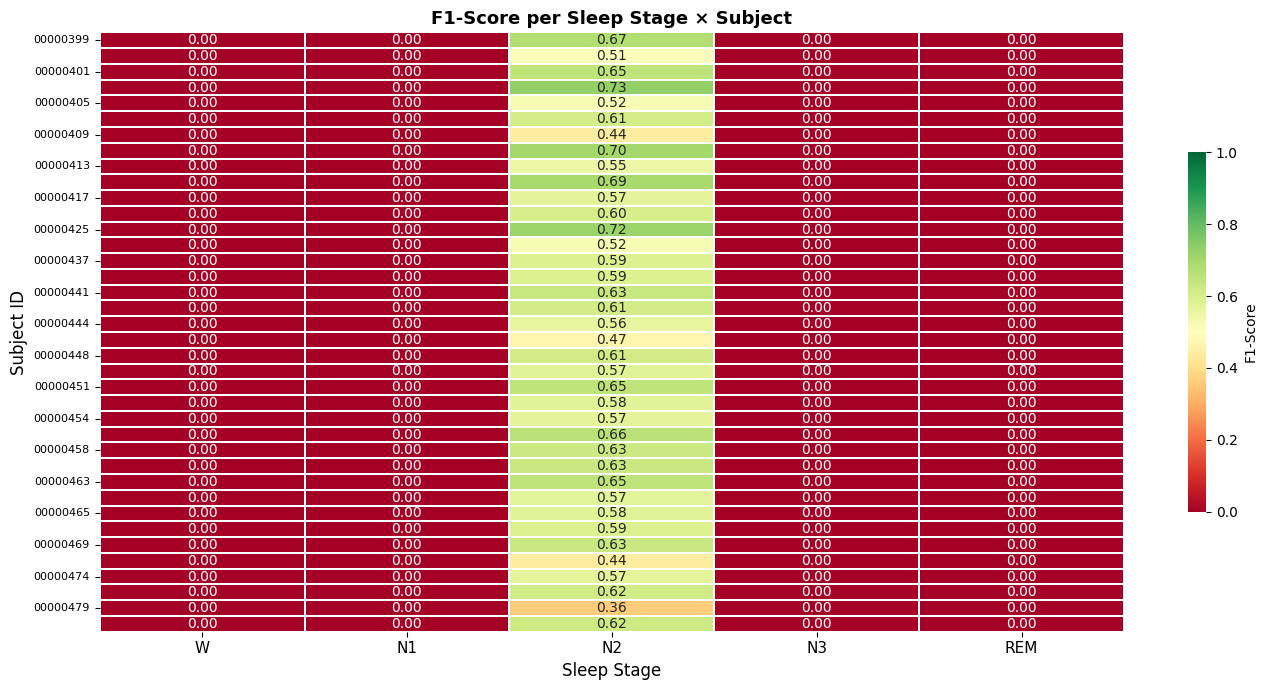

Saved: fig_f1_heatmap.png


In [6]:
fig, ax = plt.subplots(figsize=(14, 7))

f1_cols = ['f1_W', 'f1_N1', 'f1_N2', 'f1_N3', 'f1_REM']
df_f1   = df_sub.set_index('subject_id')[f1_cols].copy()
df_f1.index = [sid.split('-')[0] for sid in df_f1.index]
df_f1.columns = STAGE_NAMES

sns.heatmap(df_f1, annot=True, fmt='.2f', cmap='RdYlGn',
            vmin=0, vmax=1, linewidths=0.3, ax=ax,
            cbar_kws={'label': 'F1-Score', 'shrink': 0.6})
ax.set_xlabel('Sleep Stage', fontsize=12)
ax.set_ylabel('Subject ID', fontsize=12)
ax.set_title('F1-Score per Sleep Stage × Subject', fontsize=13, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=8, rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(EVAL_DIR, 'fig_f1_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: fig_f1_heatmap.png')

## 5. Epoch Count Distribution per Subject

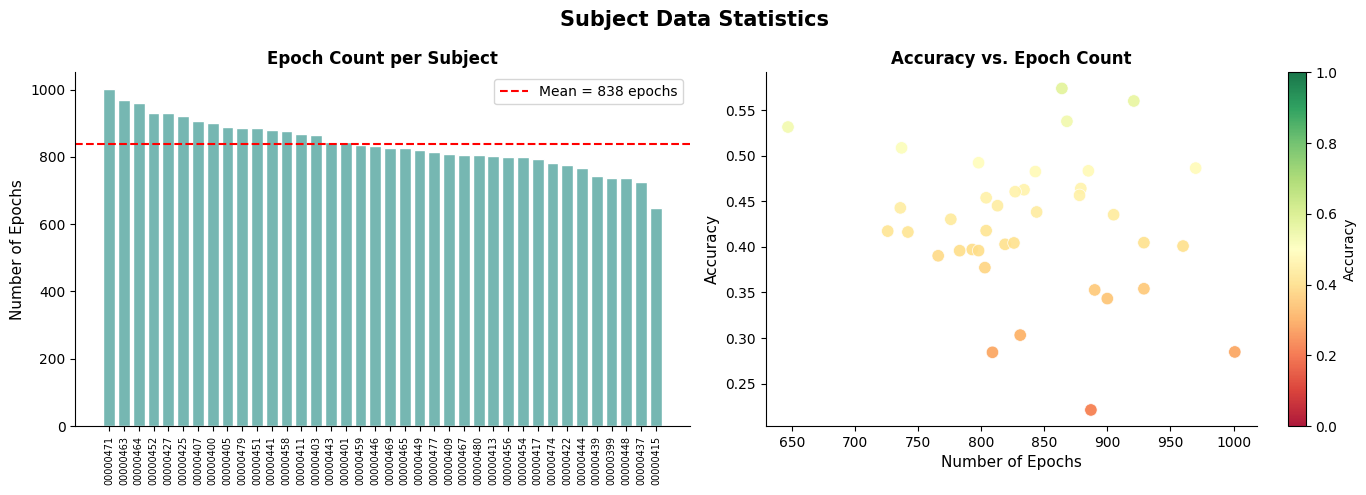

Saved: fig_epoch_stats.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Subject Data Statistics', fontsize=15, fontweight='bold')

df_sorted_ep = df_sub.sort_values('n_epochs', ascending=False).reset_index(drop=True)
short_ids_ep = [sid.split('-')[0] for sid in df_sorted_ep['subject_id']]

# ── Left: Epoch count per subject ─────────────────────────────────────────────
ax = axes[0]
ax.bar(range(len(df_sorted_ep)), df_sorted_ep['n_epochs'],
       color='#76b7b2', edgecolor='white')
ax.axhline(df_sorted_ep['n_epochs'].mean(), color='red', linestyle='--', linewidth=1.5,
           label=f"Mean = {df_sorted_ep['n_epochs'].mean():.0f} epochs")
ax.set_xticks(range(len(df_sorted_ep)))
ax.set_xticklabels(short_ids_ep, rotation=90, fontsize=7)
ax.set_ylabel('Number of Epochs', fontsize=11)
ax.set_title('Epoch Count per Subject', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.spines[['top', 'right']].set_visible(False)

# ── Right: Accuracy vs Epoch count scatter ────────────────────────────────────
ax2 = axes[1]
sc = ax2.scatter(df_sub['n_epochs'], df_sub['accuracy'],
                 c=df_sub['accuracy'], cmap='RdYlGn',
                 vmin=0, vmax=1, s=80, edgecolors='white', linewidths=0.5, alpha=0.9)
plt.colorbar(sc, ax=ax2, label='Accuracy')
ax2.set_xlabel('Number of Epochs', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Accuracy vs. Epoch Count', fontsize=12, fontweight='bold')
ax2.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(EVAL_DIR, 'fig_epoch_stats.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: fig_epoch_stats.png')

## 6. True Label Distribution (Ground Truth)

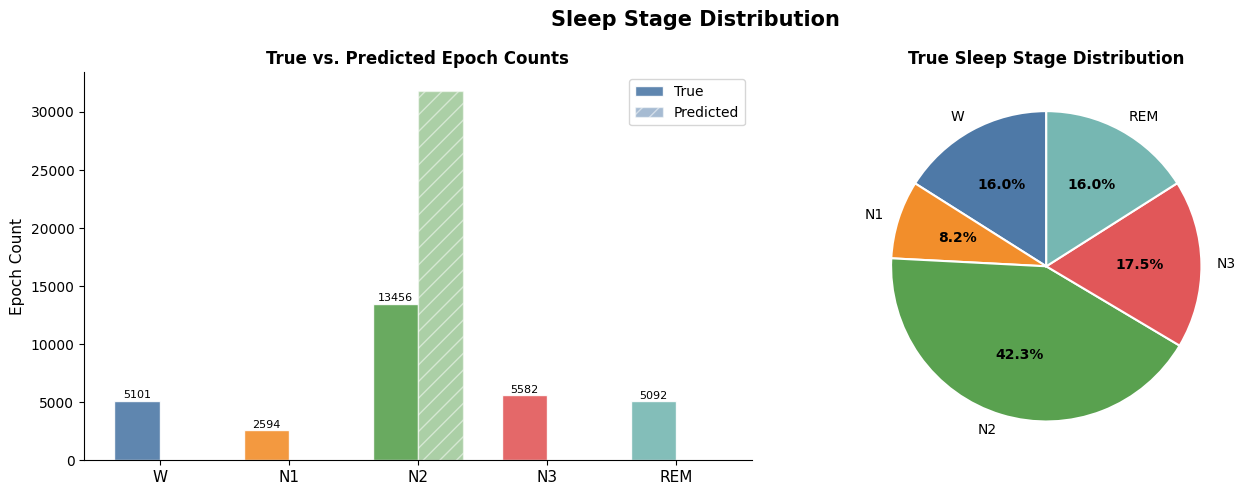

Saved: fig_stage_distribution.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Sleep Stage Distribution', fontsize=15, fontweight='bold')

# Compute true epoch counts per stage from confusion matrix
true_counts = df_cm.sum(axis=1).values   # row sums = true counts
pred_counts = df_cm.sum(axis=0).values   # col sums = predicted counts

x = np.arange(len(STAGE_NAMES))
width = 0.35

# ── Left: True vs Predicted counts ───────────────────────────────────────────
ax = axes[0]
b1 = ax.bar(x - width/2, true_counts, width, label='True', color=STAGE_COLORS, edgecolor='white', alpha=0.9)
b2 = ax.bar(x + width/2, pred_counts, width, label='Predicted', color=STAGE_COLORS, edgecolor='white', alpha=0.5, hatch='//')
ax.set_xticks(x)
ax.set_xticklabels(STAGE_NAMES, fontsize=11)
ax.set_ylabel('Epoch Count', fontsize=11)
ax.set_title('True vs. Predicted Epoch Counts', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.spines[['top', 'right']].set_visible(False)
for bar in b1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=8)

# ── Right: Pie chart of true distribution ────────────────────────────────────
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(
    true_counts, labels=STAGE_NAMES, colors=STAGE_COLORS,
    autopct='%1.1f%%', startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)
for t in autotexts:
    t.set_fontsize(10)
    t.set_fontweight('bold')
ax2.set_title('True Sleep Stage Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(EVAL_DIR, 'fig_stage_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: fig_stage_distribution.png')

## 7. Summary Table

In [9]:
print('=' * 60)
print('OVERALL RESULTS SUMMARY')
print('=' * 60)
print(f"Subjects evaluated : {overall['n_subjects']}")
print(f"Total epochs       : {overall['n_epochs']:,}")
print(f"Accuracy           : {overall['accuracy']:.4f}")
print(f"Cohen's Kappa      : {overall['kappa']:.4f}")
print(f"Mean F1            : {overall['mean_f1']:.4f}")
print(f"  F1-W             : {overall['f1_W']:.4f}")
print(f"  F1-N1            : {overall['f1_N1']:.4f}")
print(f"  F1-N2            : {overall['f1_N2']:.4f}")
print(f"  F1-N3            : {overall['f1_N3']:.4f}")
print(f"  F1-REM           : {overall['f1_REM']:.4f}")
print(f"Sensitivity (macro): {overall['sensitivity']:.4f}")
print(f"Specificity (macro): {overall['specificity']:.4f}")
print('=' * 60)
print()
print('Per-subject statistics:')
print(df_sub[['accuracy', 'kappa', 'mean_f1', 'n_epochs']].describe().round(4).to_string())

print('\n⚠️  Note: kappa=0 and F1=0 for W/N1/N3/REM indicates the model')
print('   is predicting only N2 for all epochs.')
print('   This is a known issue with domain mismatch between SHHS')
print('   pretrained weights and the custom dataset.')

OVERALL RESULTS SUMMARY
Subjects evaluated : 38
Total epochs       : 31,825
Accuracy           : 0.4228
Cohen's Kappa      : 0.0000
Mean F1            : 0.1189
  F1-W             : 0.0000
  F1-N1            : 0.0000
  F1-N2            : 0.5943
  F1-N3            : 0.0000
  F1-REM           : 0.0000
Sensitivity (macro): 0.2000
Specificity (macro): 0.8000

Per-subject statistics:
       accuracy  kappa  mean_f1   n_epochs
count   38.0000   38.0  38.0000    38.0000
mean     0.4241    0.0   0.1183   837.5000
std      0.0762    0.0   0.0156    74.3806
min      0.2210    0.0   0.0724   647.0000
25%      0.3959    0.0   0.1134   798.0000
50%      0.4242    0.0   0.1192   829.0000
75%      0.4638    0.0   0.1267   886.5000
max      0.5741    0.0   0.1459  1001.0000

⚠️  Note: kappa=0 and F1=0 for W/N1/N3/REM indicates the model
   is predicting only N2 for all epochs.
   This is a known issue with domain mismatch between SHHS
   pretrained weights and the custom dataset.
